# Basic Generator Neural Net

First, a basic generator. Lets input the PCA processed data into a small neural net and see what we get back. We are trying to recreate the target image from our brain data, and we will use simply cross entropy for our loss.

In [16]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import argparse
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

First we create the data loader and preprocess the data. In this report we have used pytorch lightning extensively. It is a very useful and intuitive framework, and one of the most useful things that I learned while writing this report. Highly recommend!

Pytorch lightning requires that you define a DataModule, and the lightning module. The Datamodule preprocesses the data for you, and loads it into the GPU if you are using it, the net module defines your net and training loop. Lightning handles all of the gpu and backprop tasks for you. 

In [14]:
class DataModule(pl.LightningDataModule):
    # Passing in all hyper parameters of the model to the parser class
    @staticmethod
    def get_HP(args = []):
        parser = argparse.ArgumentParser(description='Define model Hyperparams')
        root_dir = os.getcwd()
        parser.add_argument('--embed_size', default = 300)
        parser.add_argument('--X_train', default=os.path.join(root_dir, 'np_data/sub_01_fmri_train.npy'), type=str)
        parser.add_argument('--y_train', default=os.path.join(root_dir, 'np_data/sub_01_images_train.npy'), type=str)
        parser.add_argument('--X_test', default=os.path.join(root_dir, 'np_data/sub_01_fmri_test.npy'), type=str)
        parser.add_argument('--y_test', default=os.path.join(root_dir, 'np_data/sub_01_images_test.npy'), type=str)
        parser.add_argument('--data_dir', default=os.path.join(root_dir, 'data/simple_gen'), type=str)
        return parser.parse_args(args = args)
    
    def __init__(self, HP):
        super().__init__()
        self.HP = HP

    # For one time preprocessing of data
    def prepare_data(self):
        try: # Check if the data has already been preprocessed
            torch.load(self.HP.data_dir + '/test.h5'); del temp;
        except: # Else preprocess
            X_train = np.load(self.HP.X_train)
            y_train = np.load(self.HP.y_train)
            X_test = np.load(self.HP.X_test)
            y_test = np.load(self.HP.y_test)

            pca = PCA(n_components=300)
            pca.fit(np.concatenate((X_train, X_test), axis = 0))
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
            
            # Creating the dataset
            X_train = torch.reshape(torch.Tensor(X_train), (-1, self.HP.embed_size, 1, 1)) # transform to torch tensor
            X_test = torch.reshape(torch.Tensor(X_test), (-1, self.HP.embed_size, 1, 1)) 

            #ims train
            y_train_resized = []
            for img in y_train:
                img = Image.fromarray(img)
                img = img.resize((32, 32), Image.BICUBIC)
                y_train_resized.append(np.array(img).transpose(2, 0, 1))
            y_train = torch.Tensor(np.stack(y_train_resized, axis=0))/255

            #ims test
            y_test_resized = []
            for img in y_test:
                img = Image.fromarray(img)
                img = img.resize((32, 32), Image.BICUBIC)
                y_test_resized.append(np.array(img).transpose(2, 0, 1))
            y_test = torch.Tensor(np.stack(y_test_resized, axis=0))/255
            
            os.mkdir(self.HP.data_dir)
            torch.save({"X": X_train, "y": y_train}, self.HP.data_dir + '/train.h5')
            torch.save({"X": X_test, "y": y_test}, self.HP.data_dir + '/test.h5')    
       
    def setup(self, stage=None):
        train = torch.load(self.HP.data_dir + '/train.h5')
        self.train_ds = TensorDataset(train["X"], train["y"])
        test = torch.load(self.HP.data_dir + '/test.h5')
        self.test_ds = TensorDataset(test["X"], test["y"])
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, num_workers=1, batch_size=64, pin_memory=True, shuffle=True) # create your dataloader

    def val_dataloader(self):
        return DataLoader(self.test_ds, num_workers=1, batch_size=64) # create your dataloader)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, num_workers=1, batch_size=10) # create your dataloader)
    

        
class Generator(pl.LightningModule):
    @staticmethod
    def get_HP(args = []):
        parser = argparse.ArgumentParser(description='Define model Hyperparams')
        root_dir = os.getcwd()
        parser.add_argument('--embed_size', default = 300)
        parser.add_argument('--ngf', default = 64)
        return parser.parse_args(args = args)
    
    def __init__(self, HP):
        super().__init__()
        self.save_hyperparameters()
        self.HP = HP
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(HP.embed_size, HP.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(HP.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(HP.ngf * 8, HP.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HP.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(HP.ngf * 4, HP.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HP.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(HP.ngf * 2, HP.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(HP.ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(HP.ngf, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x):
        return self.main(x)
    
    def training_step(self, batch, batch_idx):
        fmri, ims = batch
        gen = self(fmri)
        loss = F.mse_loss(gen, ims)
        self.log('train_loss', loss, )
        return loss
    
    def validation_step(self, batch, batch_idx):
        fmri, ims = batch
        gen = self(fmri)
        loss = F.mse_loss(gen, ims)
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        fmri, ims = batch
        gen = self(fmri)
        loss = F.mse_loss(gen, ims)
        self.predictions = gen
        self.targets = ims
        self.log('test_loss', loss)
    

# early_stop_callback = EarlyStopping(
#    monitor='val_loss',
#    min_delta=0,
#    patience=20,
#    verbose=False,
#    mode='min'
# )    

# saves a file like: neuroImg-epoch0X-train_loss-55
checkpoint_callback = ModelCheckpoint(
    save_last=True,
    save_top_k=1,
    mode='min',
    monitor='train_loss',
    filename='nueroImg-{epoch:02d}-{train_loss:.4f}'
)

dm_HP = DataModule.get_HP()
dm = DataModule(dm_HP)

"""
Running our model
"""
model_HP = Generator.get_HP()
model = Generator(model_HP)

trainer = pl.Trainer(max_epochs=100, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Set SLURM handle signals.

  | Name | Type       | Params
------------------------------------
0 | main | Sequential | 5.2 M 
------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.849    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saving latest checkpoint...


1

Running our Neural net on GPU for 100 epochs. Showing the results on test data. 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10418824106454849}
--------------------------------------------------------------------------------
generated ims on the left, real ims on the right


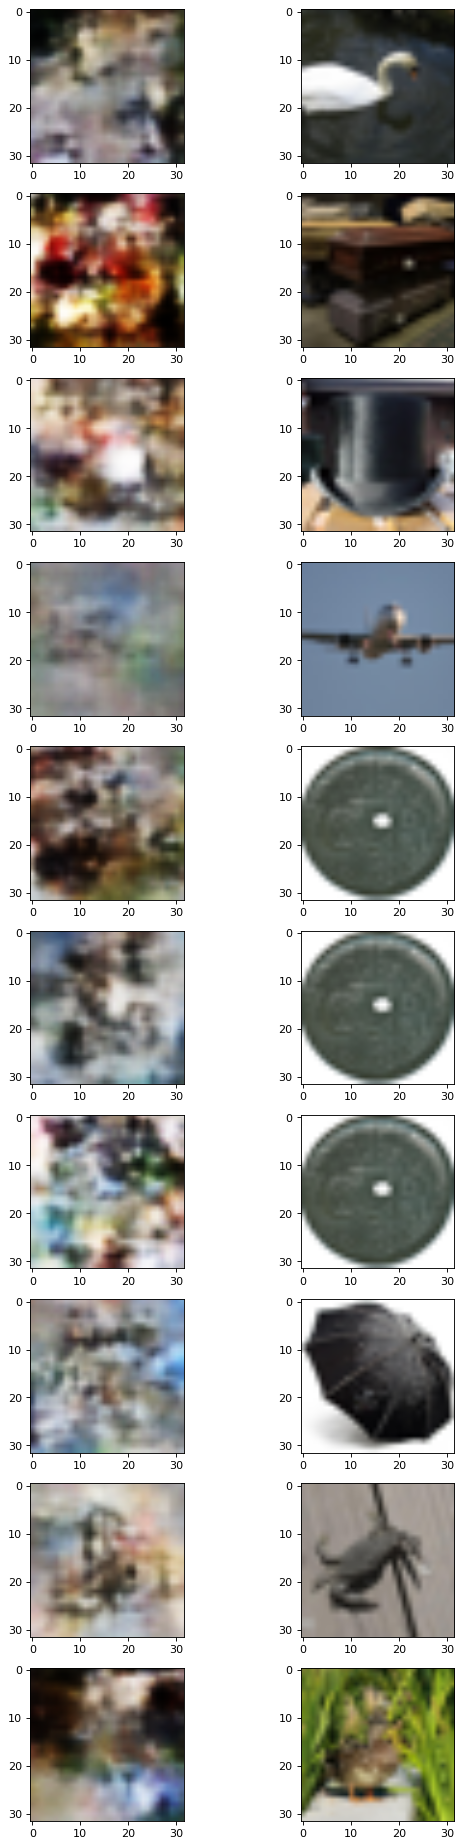

In [15]:
# This will generate prediction and target pairs
v_num = model.get_progress_bar_dict()['v_num']
trainer.test(model=model, ckpt_path=f'lightning_logs/version_{v_num}/checkpoints/last.ckpt')
predictions = model.predictions
targets = model.targets

targets = np.transpose(targets.cpu().numpy(), (0, 2, 3, 1))
predictions = np.transpose(predictions.cpu().numpy(), (0, 2, 3, 1))

R = 10
C = 2
print("generated ims on the left, real ims on the right")
plt.figure(figsize=(8, 30), dpi=80)
for i in range(10):
    plt.subplot(R, C, i*2 + 1)
    plt.imshow(predictions[i], interpolation='bilinear')
    plt.subplot(R, C, i*2 + 2)
    plt.imshow(targets[i], interpolation='bilinear')
plt.show()

Defining the Generator neural net, which simply takes in a 300 data point long representation and outputs an image. 

Not the most amazing results in this first iteration. However, it appears that some degree of color and/or shape is being captured in a few of these image recreations. Mostly however it's pretty similar between recreations. We can do better than this!